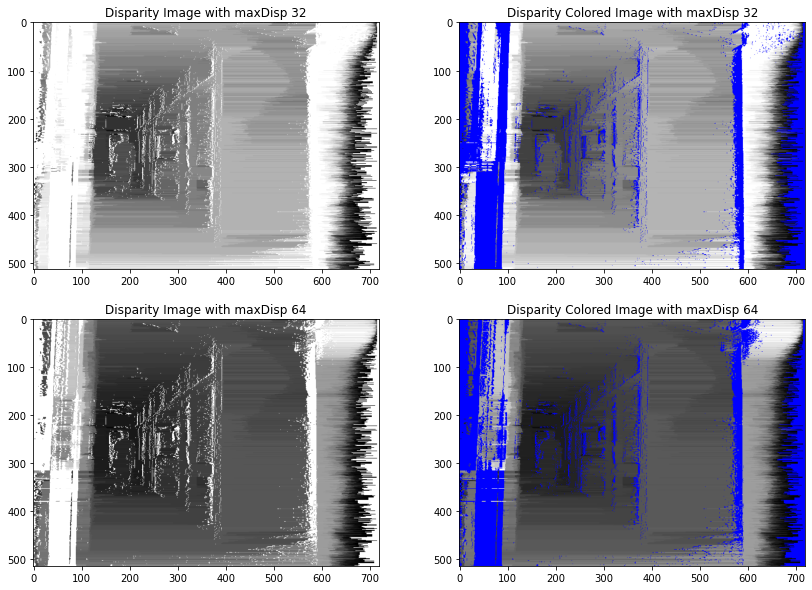

In [9]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt

# stereoDP function definition
def stereoDP(e1, e2, maxDisp, occ):
    e1Row = e1.shape[0]
    e2Row = e2.shape[0]
    D = np.zeros([e1Row+1, e2Row+1]) + float('inf')
    backTrackMat = np.zeros(D.shape)

    # Part A: Disparity matching along each epipolar lines %%%%%%%%%%%%%%%%%%%
    
    # Penalty for matching two pixels
    D[1, 1] = (e1[1] - e2[1]) ** 2
    
    # Preallocation
    for i in range(1, e1Row):
        for j in range(1, e2Row):
            if (j-maxDisp) < i < (j+maxDisp) and (i-maxDisp) < j < (i+maxDisp):
                D[0, j] = j * occ
                D[i, 0] = i * occ

                cost = (e1[i] - e2[j])**2 # Penalty

                D[i, j] = min(D[i-1, j-1] + cost, D[i-1, j] + occ, D[i, j-1] + occ)

                # Initialization
                if D[i, j] == D[i-1, j-1] + cost:
                    backTrackMat[i, j] = 2
                elif D[i, j] == D[i-1, j] + occ:
                    backTrackMat[i, j] = 0
                else:
                    backTrackMat[i, j] = 1
            else:
                pass

    # Part B: Backtracking %%%%%%%%%%%%%%%%%%
    
    disparityMat = np.zeros(e1Row)
    i = e1Row - 5
    j = e1Row - 5
    while i > 0 and j > 0:
        if backTrackMat[i, j] == 2:
            disparityMat[i] = abs(i - j)
            i = i-1
            j = j-1
        elif backTrackMat[i, j] == 1:
            j = j-1
        else:
            i = i-1
    return disparityMat

# Reading images
leftImg = cv2.imread('frameLeftgray.png', 0)
rightImg = cv2.imread('frameRightgray.png', 0)

# Converting images to double type
leftImg = np.double(leftImg)
rightImg = np.double(rightImg)

# Calling stereoDP function for each epipolar line for maxDisp 30 and 15
disparityMat_30 = np.zeros(leftImg.shape)
disparityMat_15 = np.zeros(leftImg.shape)

for row in range(leftImg.shape[0]):
    disparityArr_30 = stereoDP(leftImg[row], rightImg[row], 32, 250)
    disparityMat_30[row] = disparityArr_30
    
    disparityArr_15 = stereoDP(leftImg[row], rightImg[row], 64, 250)
    disparityMat_15[row] = disparityArr_15
    

# Normalization of output images
disparityMat_30 = 255 * disparityMat_30/(np.max(disparityMat_30))
disparityMat_30 = np.uint8(disparityMat_30)

disparityMat_15 = 255 * disparityMat_15/(np.max(disparityMat_15))
disparityMat_15 = np.uint8(disparityMat_15)

# Part C: Occluded pixels are shown in blue color %%%%%%%%%%%%%%%%

rows = disparityMat_15.shape[0]
cols = disparityMat_15.shape[1]

disparityMatCol_30 = np.zeros([rows, cols, 3])
disparityMatCol_15 = np.zeros([rows, cols, 3])

disparityMatCol_30[:, :, 1] = disparityMat_30
disparityMatCol_30[:, :, 0] = disparityMat_30

disparityMatCol_15[:, :, 1] = disparityMat_15
disparityMatCol_15[:, :, 0] = disparityMat_15

# Filling occluded pixels with blue color
disparityMat_30[disparityMat_30 == 0] = 255
disparityMatCol_30[:, :, 2] = disparityMat_30
disparityMatCol_30 = np.uint8(disparityMatCol_30)

disparityMat_15[disparityMat_15 == 0] = 255
disparityMatCol_15[:, :, 2] = disparityMat_15
disparityMatCol_15 = np.uint8(disparityMatCol_15)

# Plots
fig = plt.figure(figsize=(14,10))

ax1 = fig.add_subplot(2,2,1)
ax1.set_title('Disparity Image with maxDisp 32')
ax1.imshow(disparityMat_30, cmap='gray')

ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Disparity Colored Image with maxDisp 32')
ax2.imshow(disparityMatCol_30)

ax3 = fig.add_subplot(2,2,3)
ax3.set_title('Disparity Image with maxDisp 64')
ax3.imshow(disparityMat_15, cmap='gray')

ax4 = fig.add_subplot(2,2,4)
ax4.set_title('Disparity Colored Image with maxDisp 64')
ax4.imshow(disparityMatCol_15)